In [104]:
import eredivisie_nlp as enlp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split
from statsmodels.api import OLS
from statistics import median

In [107]:
df_total = pd.read_pickle(enlp.determine_root() + "/data/grades+twitter.pkl")
# normalize the fotmob scores, to have the same average as AD and VI
df_total.FM = df_total.FM
df_total.reset_index(inplace=True, drop=True)

In [116]:
df_players = df_total[df_total.player_id.str.contains("match_") == False]
players = pd.read_csv(enlp.determine_root() + "/data/players.csv", index_col=[0])
df_players = df_players.merge(players[['position', 'player_id']], on='player_id')
df_total = df_total.merge(players[['position', 'player_id']], on='player_id')

In [54]:
def to_rel_avg(scores, avg_low, avg_high):
    rel_avg = []
    for s in scores:
        if s > avg_high:
            rel_avg.append(1)
        elif s < avg_low:
            rel_avg.append(-1)
        else:
            rel_avg.append(0)

    return rel_avg

In [55]:
def cust_round(num):
    if num > 0.33:
        return 1
    elif num > -0.33:
        return 0
    else:
        return -1

In [56]:
def aggregate_loop(it1, hop, print_drop = False):
    """
    [1, 2, 3, 4, 5, 6] with hop 2 becomes [1.5, 3.5, 5.5] and with hop 3: [2, 5]

    :param it1: first iterable of scores/grades
    :param it2: first iterable of scores/grades
    :param hop: number of observations to average over
    :return: two lists containing the lists averaged per hop
    """
    new_list = []

    # subset iterables to be divisible by hop
    max_len = len(it1) - len(it1) % hop
    if print_drop:
        print(f"Dropping {len(it1) % hop} out of {len(it1)} observations.")
    it1 = it1[:max_len]

    # caluclate the average for each of the hops
    for start in range(0, len(it1), hop):
        end = start + hop
        sub_it1 = it1[start:end]
        new_list.append(cust_round(sum(sub_it1) / len(sub_it1)))

    return new_list

In [112]:
df_total['AD_avg'] = to_rel_avg(df_total.AD, 6.0, 6.9)
df_total['VI_avg'] = to_rel_avg(df_total.VI, 6.0, 6.9)
df_total['FM_avg'] = to_rel_avg(df_total.FM, 5.5, 6.4)
df_total['pat_avg'] = to_rel_avg(df_total.score_pattern, 0, 0)
df_total['rob_avg'] = to_rel_avg(df_total.score_robbert, 0, 0)

In [113]:
print(mean_absolute_error(df_total.AD_avg, df_total.VI_avg))
print(mean_absolute_error(df_total.AD_avg, df_total.FM_avg))
print(mean_absolute_error(df_total.FM_avg, df_total.VI_avg))

0.40900109769484083
0.5435784851811196
0.4177826564215148


In [119]:
position_dict = {'Centre-Forward': 'Forward',
                 'Goalkeeper': 'Goalkeeper',
                 'Attacking Midfield': 'Midfield',
                 'Left Winger': 'Forward',
                 'Right Winger': 'Forward',
                 'Centre-Back': 'Back',
                 'Left-Back': 'Back',
                 'Central Midfield': 'Midfield',
                 'Defensive Midfield': 'Midfield',
                 'Right-Back': 'Back',
                 'Right Midfield': 'Midfield'}
df_total['pos_std'] = df_total.position.map(position_dict)

In [122]:
fw = df_total[df_total.pos_std == 'Forward']
mf = df_total[df_total.pos_std == 'Midfield']
bk = df_total[df_total.pos_std == 'Back']
gk = df_total[df_total.pos_std == 'Goalkeeper']

0.5449074074074074
0.5883333333333334
0.48546296296296293
0.3824074074074074
0.4962962962962963
0.41203703703703703


In [130]:
# forward
print((mean_absolute_error(fw.AD, fw.VI) + mean_absolute_error(fw.AD, fw.FM) + mean_absolute_error(fw.FM, fw.VI)) / 3)
# midfielder
print((mean_absolute_error(mf.AD, mf.VI) + mean_absolute_error(mf.AD, mf.FM) + mean_absolute_error(mf.FM, mf.VI)) / 3)
# back
print((mean_absolute_error(bk.AD, bk.VI) + mean_absolute_error(bk.AD, bk.FM) + mean_absolute_error(bk.FM, bk.VI)) / 3)
# goalkeeper
print((mean_absolute_error(gk.AD, gk.VI) + mean_absolute_error(gk.AD, gk.FM) + mean_absolute_error(gk.FM, gk.VI)) / 3)

0.5395679012345679
0.5278575225943647
0.5405459254831638
0.7174796747967479


# Plot dataset size dependent on criterium of num_tweets

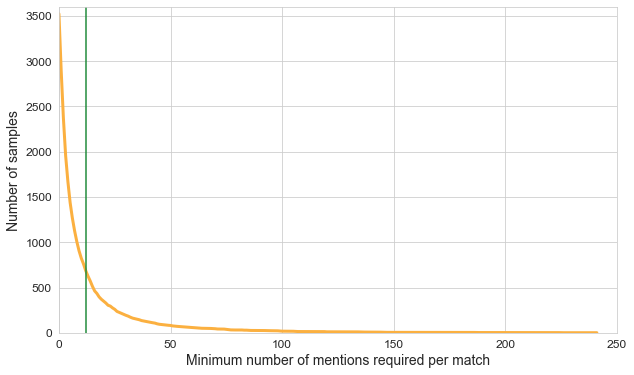

In [57]:
sizes = [df_players[df_players.num_tweets > x].shape[0] for x in range(0, 242)]
fig = plt.figure(figsize=[10,6])
plt.plot(sizes, color = '#fbb040', linewidth=3)
plt.xlim([0, 250])
plt.ylim(0, 3600)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Minimum number of mentions required per match', size=14)
plt.ylabel('Number of samples', size=14)
plt.vlines(12, ymin=0, ymax=3600, color='#208b3a')
plt.show()

In [58]:
working_df = df_players[df_players.num_tweets > 12].reset_index(drop=True)
udf = df_players[df_players.num_tweets <= 12].reset_index(drop=True)

# Plot heatmaps

In [59]:
def get_heatmap(media_source, twitter_source, df, acc=False):
    # get necessary data
    media = np.zeros(df.shape[0])
    if media_source == 'AD':
        above = df[media_source] > 6.9
        below = df[media_source] < 6
    elif media_source == 'VI':
        above = df[media_source] > 6.9
        below = df[media_source] < 6
    elif media_source == 'FM':
        above = df[media_source] > 6.4
        below = df[media_source] < 5.5

    # set media grades
    for x in range(len(media)):
        if above[x]:
            media[x] = 2
        elif below[x]:
            media[x] = 0
        else:
            media[x] = 1


    twitter = np.zeros(df.shape[0])
    column2 = f'score_{twitter_source.lower()}'
    above = df[column2] > 0
    below = df[column2] < 0

    # set twitter grades
    for x in range(len(twitter)):
        if above[x]:
            twitter[x] = 2
        elif below[x]:
            twitter[x] = 0
        else:
            twitter[x] = 1

    if acc:
        return accuracy_score(media, twitter)
    else:
        return confusion_matrix(media, twitter, labels=[0, 1, 2])

In [60]:
media = ['AD', 'AD', 'VI', 'VI', 'FM', 'FM']
twitter = ['RobBERT', 'pattern', 'RobBERT', 'pattern', 'RobBERT', 'pattern']
accs = [get_heatmap(m, t, df=working_df, acc=True) for m, t in zip(media, twitter)]
robbert_acc = sum([accs[0], accs[2], accs[4]]) / 3
pattern_acc = sum([accs[1], accs[3], accs[5]]) / 3

In [61]:
robbert_acc, pattern_acc

(0.5170068027210885, 0.4261418853255588)

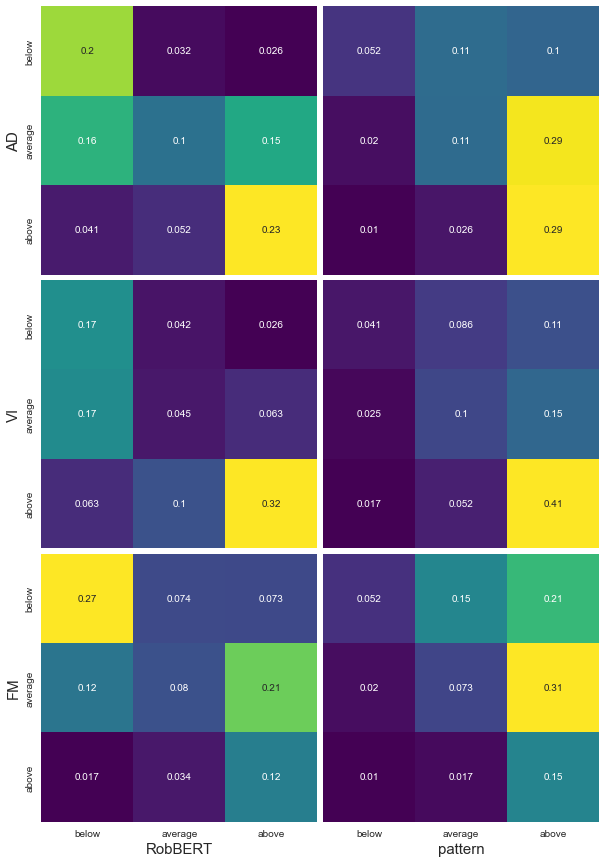

In [62]:
axis_labels = ['below', 'average', 'above']

_, axs = plt.subplots(nrows = 3, ncols = 2, figsize=[10,15])
cf = get_heatmap('AD', 'RobBERT', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=False, yticklabels=axis_labels, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[0,0])
cf = get_heatmap('AD', 'pattern', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=False, yticklabels=False, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[0,1])
cf = get_heatmap('VI', 'RobBERT', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=False, yticklabels=axis_labels, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[1,0])
cf = get_heatmap('VI', 'pattern', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=False, yticklabels=False, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[1,1])
cf = get_heatmap('FM', 'RobBERT', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=axis_labels, yticklabels=axis_labels, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[2,0])
cf = get_heatmap('FM', 'pattern', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=axis_labels, yticklabels=False, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[2,1])

axs[0,0].set_ylabel('AD', size=15)
axs[1,0].set_ylabel('VI', size=15)
axs[2,0].set_ylabel('FM', size=15)
axs[2,0].set_xlabel('RobBERT', size=15)
axs[2,1].set_xlabel('pattern', size=15)

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig(enlp.determine_root() + "/res/figures/general_heatmaps_players.png", dpi=600)

plt.show()

# Figure 2, predictive power of Twitter scores for Media grades

In [63]:
working_df[['AD', 'VI', 'FM', 'score_pattern', 'score_robbert']].corr()

,AD,VI,FM,score_pattern,score_robbert
AD,1.000000,0.757034,0.672835,0.444205,0.539899
VI,0.757034,1.000000,0.777701,0.411706,0.548634
FM,0.672835,0.777701,1.000000,0.292728,0.401940
score_pattern,0.444205,0.411706,0.292728,1.000000,0.607614
score_robbert,0.539899,0.548634,0.401940,0.607614,1.000000


In [64]:
def lin_reg(media, df):
    print(f"Values for: {media}")
    X = df.score_robbert.values.reshape(-1, 1)
    y = df[media].values.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    regressor = LinearRegression()

    regressor.fit(X_train, y_train)

    print(OLS(y_train,X_train).fit().summary())

    print(f"Intercept: {round(regressor.intercept_[0], 2)}")
    print(f"Coefficient: {round(regressor.coef_[0][0], 2)}")

    y_pred = regressor.predict(X_test)

    print(f"MAE: {round(mean_absolute_error(y_test, y_pred), 2)}")

lin_reg('AD', working_df[np.isnan(working_df.score_robbert) == False])

Values for: AD
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              1.737
Date:                Fri, 08 Jul 2022   Prob (F-statistic):                       0.188
Time:                        09:38:45   Log-Likelihood:                         -1789.5
No. Observations:                 548   AIC:                                      3581.
Df Residuals:                     547   BIC:                                      3585.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

# Additional analyses for different sections

In [65]:
# section 4.1
no_data = df_players.num_tweets[df_players.num_tweets == 0].shape[0]
print(f"No data for {no_data} out of {df_players.shape[0]} player appearances.")

No data for 830 out of 4351 player appearances.


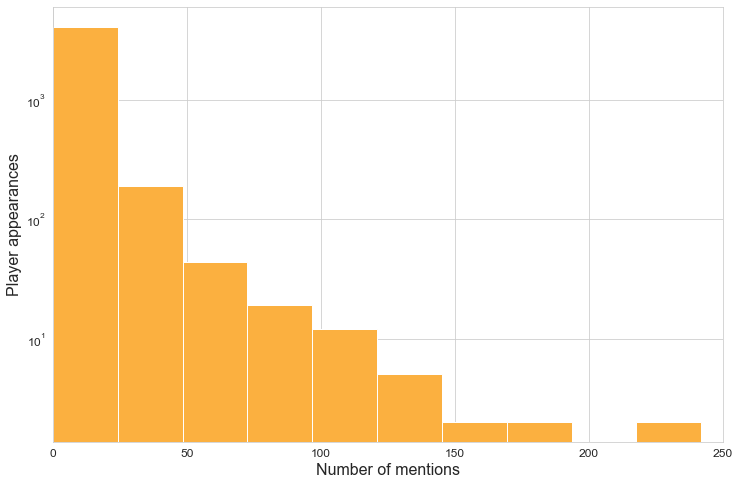

In [66]:
# section 4.1
fig = plt.figure(figsize=[12,8])
plt.hist(df_players.num_tweets, color='#fbb040')
plt.yscale('log')
plt.xlabel('Number of mentions', size=16)
plt.ylabel('Player appearances', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.savefig(enlp.determine_root() + "/res/figures/num_tweets.png", dpi=600)
plt.xlim([0, 250])
plt.show()

In [67]:
roles_recode = {
    'Centre-Back': 'back',
    'Centre-Forward': 'forward',
    'Right-Back': 'back',
    'Attacking Midfield': 'midfield',
    'Central Midfield': 'midfield',
    'Defensive Midfield': 'midfield',
    'Left-Back': 'back',
    'Goalkeeper': 'goalkeeper',
    'Right Winger': 'forward',
    'Left Winger': 'forward',
    'Right Midfield': 'midfield',
    'Left Midfield': 'midfield'
}
df_players['position_std'] = df_players.position.map(roles_recode)
goalies = df_players[df_players.position_std == 'goalkeeper'].num_tweets
back = df_players[df_players.position_std == 'back'].num_tweets
midfield = df_players[df_players.position_std == 'midfield'].num_tweets
forward = df_players[df_players.position_std == 'forward'].num_tweets

In [68]:
print(sum(goalies) / len(goalies))
print(sum(back) / len(back))
print(sum(midfield) / len(midfield))
print(sum(forward) / len(forward))

11.554878048780488
4.329946204423192
6.876377952755906
11.262037037037038


# Plot heatmaps

In [69]:
media = ['AD', 'AD', 'VI', 'VI', 'FM', 'FM']
twitter = ['RobBERT', 'pattern', 'RobBERT', 'pattern', 'RobBERT', 'pattern']
accs = [get_heatmap(m, t, df=working_df, acc=True) for m, t in zip(media, twitter)]
robbert_acc = sum([accs[0], accs[2], accs[4]]) / 3
pattern_acc = sum([accs[1], accs[3], accs[5]]) / 3

In [70]:
robbert_acc, pattern_acc

(0.5170068027210885, 0.4261418853255588)

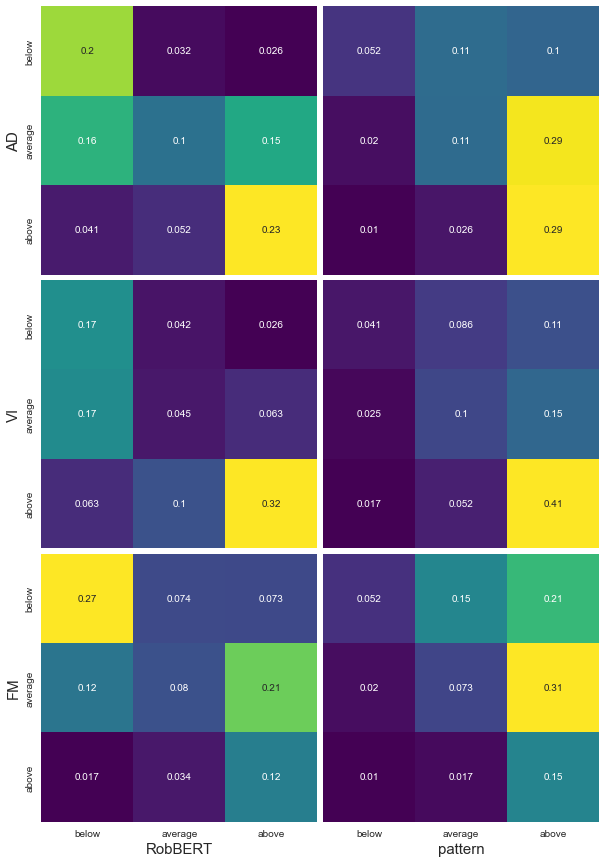

In [71]:
axis_labels = ['below', 'average', 'above']

_, axs = plt.subplots(nrows = 3, ncols = 2, figsize=[10,15])
cf = get_heatmap('AD', 'RobBERT', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=False, yticklabels=axis_labels, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[0,0])
cf = get_heatmap('AD', 'pattern', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=False, yticklabels=False, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[0,1])
cf = get_heatmap('VI', 'RobBERT', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=False, yticklabels=axis_labels, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[1,0])
cf = get_heatmap('VI', 'pattern', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=False, yticklabels=False, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[1,1])
cf = get_heatmap('FM', 'RobBERT', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=axis_labels, yticklabels=axis_labels, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[2,0])
cf = get_heatmap('FM', 'pattern', working_df)
sns.heatmap(cf/np.sum(cf), annot=True, xticklabels=axis_labels, yticklabels=False, cmap=sns.color_palette("viridis", as_cmap=True), cbar=False, ax=axs[2,1])

axs[0,0].set_ylabel('AD', size=15)
axs[1,0].set_ylabel('VI', size=15)
axs[2,0].set_ylabel('FM', size=15)
axs[2,0].set_xlabel('RobBERT', size=15)
axs[2,1].set_xlabel('pattern', size=15)

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig(enlp.determine_root() + "/res/figures/general_heatmaps_players.png", dpi=600)

plt.show()

# Figure 2, predictive power of Twitter scores for Media grades

In [72]:
working_df[['AD', 'VI', 'FM', 'score_pattern', 'score_robbert']].corr()

,AD,VI,FM,score_pattern,score_robbert
AD,1.000000,0.757034,0.672835,0.444205,0.539899
VI,0.757034,1.000000,0.777701,0.411706,0.548634
FM,0.672835,0.777701,1.000000,0.292728,0.401940
score_pattern,0.444205,0.411706,0.292728,1.000000,0.607614
score_robbert,0.539899,0.548634,0.401940,0.607614,1.000000


In [73]:
def lin_reg(media, df):
    print(f"Values for: {media}")
    X = df.score_robbert.values.reshape(-1, 1)
    y = df[media].values.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    regressor = LinearRegression()

    regressor.fit(X_train, y_train)

    print(OLS(y_train,X_train).fit().summary())

    print(f"Intercept: {round(regressor.intercept_[0], 2)}")
    print(f"Coefficient: {round(regressor.coef_[0][0], 2)}")

    y_pred = regressor.predict(X_test)

    print(f"MAE: {round(mean_absolute_error(y_test, y_pred), 2)}")

lin_reg('AD', working_df[np.isnan(working_df.score_robbert) == False])

Values for: AD
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              1.737
Date:                Fri, 08 Jul 2022   Prob (F-statistic):                       0.188
Time:                        09:38:49   Log-Likelihood:                         -1789.5
No. Observations:                 548   AIC:                                      3581.
Df Residuals:                     547   BIC:                                      3585.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

# Additional analyses for different sections

In [74]:
# section 4.1
no_data = df_players.num_tweets[df_players.num_tweets == 0].shape[0]
print(f"No data for {no_data} out of {df_players.shape[0]} player appearances.")

No data for 830 out of 4351 player appearances.


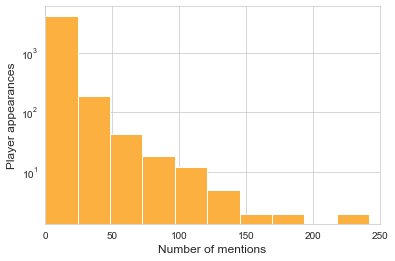

In [75]:
# section 4.1
plt.hist(df_players.num_tweets, color='#fbb040')
plt.yscale('log')
plt.xlabel('Number of mentions', size=12)
plt.ylabel('Player appearances', size=12)
plt.savefig(enlp.determine_root() + "/res/figures/num_tweets.png", dpi=600)
plt.xlim([0, 250])
plt.show()

In [ ]:
roles_recode = {
    'Centre-Back': 'back',
    'Centre-Forward': 'forward',
    'Right-Back': 'back',
    'Attacking Midfield': 'midfield',
    'Central Midfield': 'midfield',
    'Defensive Midfield': 'midfield',
    'Left-Back': 'back',
    'Goalkeeper': 'goalkeeper',
    'Right Winger': 'forward',
    'Left Winger': 'forward',
    'Right Midfield': 'midfield',
    'Left Midfield': 'midfield'
}
df_players['position_std'] = df_players.position.map(roles_recode)
goalies = df_players[df_players.position_std == 'goalkeeper'].num_tweets
back = df_players[df_players.position_std == 'back'].num_tweets
midfield = df_players[df_players.position_std == 'midfield'].num_tweets
forward = df_players[df_players.position_std == 'forward'].num_tweets

In [ ]:
print(sum(goalies) / len(goalies))
print(sum(back) / len(back))
print(sum(midfield) / len(midfield))
print(sum(forward) / len(forward))

# Number of tweets necessary per player

In [78]:
working_df['AD_avg'] = to_rel_avg(working_df.AD, 6.0, 6.9)
working_df['VI_avg'] = to_rel_avg(working_df.VI, 6.0, 6.9)
working_df['FM_avg'] = to_rel_avg(working_df.FM, 5.5, 6.4)

In [79]:
p_acc = []
r_acc = []
for x in range(71):
    sub_working_df = df_players[df_players.num_tweets > x].reset_index(drop=True)
    media = ['AD', 'AD', 'VI', 'VI', 'FM', 'FM']
    twitter = ['RobBERT', 'pattern', 'RobBERT', 'pattern', 'RobBERT', 'pattern']
    accs = [get_heatmap(m, t, df=sub_working_df, acc=True) for m, t in zip(media, twitter)]
    p_acc.append(sum([accs[1], accs[3], accs[5]]) / 3)
    r_acc.append(sum([accs[0], accs[2], accs[4]]) / 3)

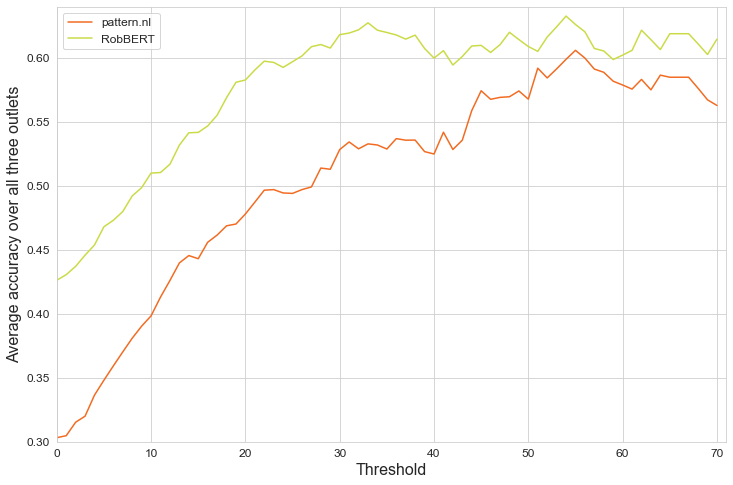

In [80]:
fig = plt.figure(figsize=[12,8])
plt.plot(range(71), p_acc, color='#f26b21')
plt.plot(range(71), r_acc, color='#cbdb47')
plt.ylabel('Average accuracy over all three outlets', size=16)
plt.xlabel('Threshold', size=16)
plt.legend(['pattern.nl', 'RobBERT'], fontsize=12)
plt.xlim([0, 71])
plt.ylim([0.30, 0.64])
plt.xticks(range(0,71,10), size=12)
plt.yticks([n / 100 for n in range(30, 65, 5)], size=12)

plt.show()

In [81]:
r_acc[0]

0.42629934677648396

# Level of aggregation necessary for unpopular players

In [82]:
udf = udf.sort_values(by='datetime', ascending=False).reset_index(drop=True)

udf['AD_avg'] = to_rel_avg(udf.AD, 6.0, 6.9)
udf['VI_avg'] = to_rel_avg(udf.VI, 6.0, 6.9)
udf['FM_avg'] = to_rel_avg(udf.FM, 5.5, 6.4)
udf['pat_avg'] = to_rel_avg(udf.score_pattern, 0, 0)
udf['rob_avg'] = to_rel_avg(udf.score_robbert, 0, 0)
udf

,datetime,player_id,AD,VI,FM,hashtag,home,away,score_manual,score_pattern,num_tweets,score_robbert,position,AD_avg,VI_avg,FM_avg,pat_avg,rob_avg
0,2022-02-20 15:45:00+00:00,drommel_psv,6.0,6.0,4.3,#psvhee,PSV,sc Heerenveen,NaN,-0.1,7.0,-0.1,Goalkeeper,0,0,-1,-1,-1
1,2022-02-20 15:45:00+00:00,ramselaar_utr,5.0,5.5,4.7,#utrvit,FC Utrecht,Vitesse,NaN,-0.3,1.0,-0.3,Attacking Midfield,-1,-1,-1,-1,-1
2,2022-02-20 15:45:00+00:00,haye_hee,5.5,7.0,5.0,#psvhee,PSV,sc Heerenveen,NaN,0.2,2.0,-0.1,Defensive Midfield,-1,1,-1,1,-1
3,2022-02-20 15:45:00+00:00,gotze_psv,6.0,8.0,6.4,#psvhee,PSV,sc Heerenveen,NaN,0.3,5.0,-0.1,Attacking Midfield,0,1,0,1,-1
4,2022-02-20 15:45:00+00:00,vandestreek_utr,5.0,5.0,4.9,#utrvit,FC Utrecht,Vitesse,NaN,0.0,2.0,0.0,Attacking Midfield,-1,-1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3660,2021-08-13 18:00:00+00:00,lucassen_gae,5.0,5.5,4.4,#gaehee,Go Ahead Eagles,sc Heerenveen,NaN,0.3,5.0,0.3,Right-Back,-1,-1,-1,1,1
3661,2021-08-13 18:00:00+00:00,kuipers_gae,6.0,6.5,5.4,#gaehee,Go Ahead Eagles,sc Heerenveen,NaN,NaN,0.0,NaN,Left-Back,0,0,-1,0,0
3662,2021-08-13 18:00:00+00:00,vanbeek_hee,6.0,6.5,5.2,#gaehee,Go Ahead Eagles,sc Heerenveen,NaN,0.0,2.0,0.4,Centre-Back,0,0,-1,0,1
3663,2021-08-13 18:00:00+00:00,kaib_hee,6.0,6.0,4.9,#gaehee,Go Ahead Eagles,sc Heerenveen,NaN,NaN,0.0,NaN,Left-Back,0,0,-1,0,0


In [83]:
print(f"Average number of tweets per appearance in udf: {sum(udf.num_tweets) / udf.shape[0]}")
print(f"Median number of tweets per appearance in udf: {median(udf.num_tweets)}")

Average number of tweets per appearance in udf: 3.1386084583901774
Median number of tweets per appearance in udf: 2.0


In [84]:
# amount of matches to aggregate over
def aggregate_df(agg):

    players = list(set(udf.player_id))
    new_df = pd.DataFrame()

    for player in players[:10]:

        # subset current df
        sub_udf = udf[udf.player_id == player][['AD_avg', 'VI_avg', 'FM_avg', 'pat_avg', 'rob_avg']]

        # if we have enough data left
        if sub_udf.shape[0] / agg >= 1:
            hop_output = [aggregate_loop(sub_udf[col], agg) for col in sub_udf.columns]

            new_df = pd.concat([new_df, pd.DataFrame({col: out for out, col in zip(hop_output, sub_udf.columns)})]).reset_index(drop=True)
    return new_df

In [85]:
p_accs = [0.3032282495503172]
r_accs = [0.42629934677648396]
sample_size = [udf.shape[0]]

for x in range(1, 22):
    df = aggregate_df(x)
    if df.shape[0] > 0:
        p_accs.append((accuracy_score(df.AD_avg, df.pat_avg) + accuracy_score(df.VI_avg, df.pat_avg) + accuracy_score(df.FM_avg, df.pat_avg)) / 3)
        r_accs.append((accuracy_score(df.AD_avg, df.rob_avg) + accuracy_score(df.VI_avg, df.rob_avg) + accuracy_score(df.FM_avg, df.rob_avg)) / 3)
        sample_size.append(df.shape[0])
    else:
        print(f"Max level of aggregation: {x}")
        break

Max level of aggregation: 20


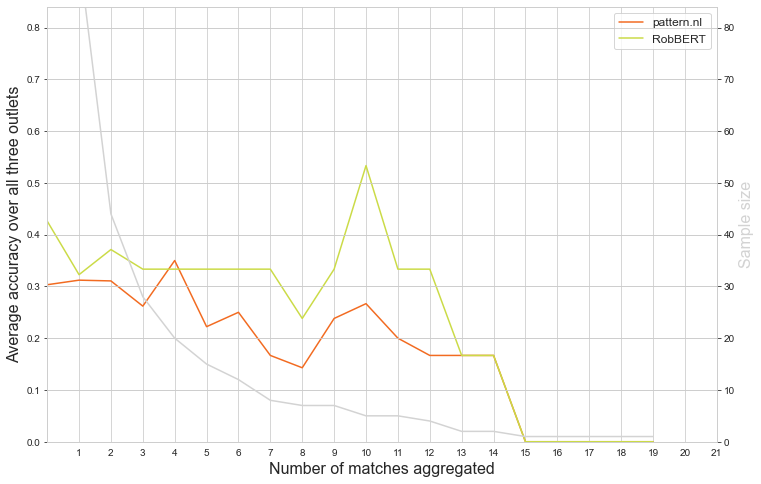

In [86]:
fig, ax = plt.subplots(figsize=[12,8])
ax.plot(range(0,x), p_accs, color='#f26b21')
ax.plot(range(0,x), r_accs, color='#cbdb47')
ax.legend(['pattern.nl', 'RobBERT'], fontsize=12)
ax.set_xticks(range(1, 23))
ax.set_xlim([0, 21])
ax.set_ylim([0, 0.84])
ax.set_ylabel('Average accuracy over all three outlets', size=16)
ax.set_xlabel('Number of matches aggregated', size=16)
ax.legend(['pattern.nl', 'RobBERT'], fontsize=12)

ax2 = ax.twinx()
ax2.plot(sample_size, color='lightgrey')
ax2.set_ylim([0, 84])
ax2.set_ylabel('Sample size', color='lightgrey', size=16)
plt.show()

# Final final analysis

In [87]:
working_df['pat_avg'] = to_rel_avg(working_df.score_pattern, 0, 0)
working_df['rob_avg'] = to_rel_avg(working_df.score_robbert, 0, 0)
working_df

,datetime,player_id,AD,VI,FM,hashtag,home,away,score_manual,score_pattern,num_tweets,score_robbert,position,AD_avg,VI_avg,FM_avg,pat_avg,rob_avg
0,2021-09-25 16:45:00+00:00,alvarez_aja,8.0,7.5,6.4,#ajagro,AFC Ajax,FC Groningen,NaN,0.2,27.0,0.1,Defensive Midfield,1,1,0,1,1
1,2021-10-03 12:30:00+00:00,alvarez_aja,6.0,6.5,5.7,#ajautr,AFC Ajax,FC Utrecht,NaN,0.0,15.0,-0.1,Defensive Midfield,0,0,0,0,-1
2,2021-11-07 19:00:00+00:00,alvarez_aja,6.0,5.0,5.1,#ajagae,AFC Ajax,Go Ahead Eagles,NaN,-0.2,14.0,-0.3,Defensive Midfield,0,-1,-1,-1,-1
3,2021-08-14 19:00:00+00:00,alvarez_aja,7.0,7.0,5.8,#ajanec,AFC Ajax,NEC Nijmegen,NaN,0.2,25.0,-0.1,Defensive Midfield,1,1,0,1,-1
4,2021-10-24 14:45:00+00:00,alvarez_aja,6.5,7.0,5.8,#ajapsv,AFC Ajax,PSV,NaN,0.1,27.0,-0.1,Defensive Midfield,0,1,0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,2021-10-30 14:30:00+00:00,delange_twe,5.5,4.5,2.0,#psvtwe,PSV,FC Twente,NaN,0.1,17.0,-0.0,Goalkeeper,-1,-1,-1,1,0
682,2022-02-13 13:30:00+00:00,vanhooijdonk_hee,6.0,4.5,4.3,#heenec,sc Heerenveen,NEC Nijmegen,NaN,-0.0,25.0,-0.2,Centre-Forward,0,-1,-1,0,-1
683,2022-02-06 13:30:00+00:00,oosting_wil,8.0,8.0,6.9,#wilrkc,Willem II,RKC Waalwijk,NaN,0.1,50.0,0.2,Attacking Midfield,1,1,1,1,1
684,2022-01-16 13:30:00+00:00,coremans_spa,4.0,4.5,3.5,#camspa,SC Cambuur,Sparta Rotterdam,NaN,-0.0,28.0,-0.1,Goalkeeper,-1,-1,-1,0,-1


In [88]:
(mean_absolute_error(working_df.AD_avg, working_df.rob_avg) + mean_absolute_error(working_df.VI_avg, working_df.rob_avg) + mean_absolute_error(working_df.FM_avg, working_df.rob_avg)) / 3

0.56511175898931

In [89]:
mean_absolute_error(working_df.FM_avg, working_df.pat_avg)

0.9518950437317785

In [90]:
(mean_absolute_error(working_df.AD_avg, working_df.pat_avg) + mean_absolute_error(working_df.VI_avg, working_df.pat_avg) + mean_absolute_error(working_df.FM_avg, working_df.pat_avg)) / 3

0.729348882410107